In [1]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tflib.init_tf()

#URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'
#with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
file = '/data/datasets/models/stylegan/karras2019stylegan-ffhq-1024x1024.pkl'
with open(file, 'rb') as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [4]:
def generate_image(latent_vector, size = (256, 256)):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size == (1024, 1024):
        return img
    return img.resize(size)
    
def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()
    

In [5]:
import cv2


def generate_image_array(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    return img_array 

## jupyter 有个bug 无法正常查看视频 
def write_video(file, latent_v1, latent_v2, video_frame_rate=24, video_size=512):
    forcc = cv2.VideoWriter_fourcc(*'MP4V')
    video_out = cv2.VideoWriter(file, forcc, video_frame_rate, (video_size, video_size))
    
    steps = video_frame_rate * 8
    for i in range(steps):
        r1 = (steps - i) / steps 
        r2 = i / steps 
        
        new_latent = latent_v1 * r1 + latent_v2 * r2 
        
        frame = generate_image_array(new_latent)
                
        video_frame = PIL.Image.fromarray(frame, 'RGB').resize((video_size, video_size))
        video_out.write(cv2.cvtColor(np.array(video_frame).astype('uint8'), cv2.COLOR_RGB2BGR))
        #video_out.write(np.array(video_frame).astype('uint8'))
        
    video_out.release()
    


In [6]:
import math
## 保存长图 
def save_images(file, imgs, w, h, col=4):
    row = math.ceil(len(imgs) / col)
    canvas = PIL.Image.new('RGB', (w * col, h * row), 'white')
    
    for i, img in enumerate(imgs):
        _r, _c = int(i/col), int(i%col)
        canvas.paste(img, (_c * w, _r * h))
    canvas.save(file)

def draw_style_mixing_figure(file, latent_v1, latent_v2):
    imgs = [] 
    img_size = 512
    steps = 16
    for i in range(steps):
        r1 = (steps - i) / steps 
        r2 = i / steps 
        
        new_latent = latent_v1 * r1 + latent_v2 * r2 
        imgs.append(generate_image(new_latent, (img_size, img_size)))
        
    save_images(file, imgs, img_size, img_size, 2)
    

In [8]:
# Loading already learned representations
donald_trump = np.load('ffhq_dataset/latent_representations/donald_trump_01.npy')
hillary_clinton = np.load('ffhq_dataset/latent_representations/hillary_clinton_01.npy')

# Of course you can learn your own vectors using two scripts

# 1) Extract and align faces from images
# python align_images.py raw_images/ aligned_images/

# 2) Find latent representation of aligned images
# python encode_images.py aligned_images/ generated_images/ latent_representations/

lat_dir = '/tf/pdev/stylegan-encoder/latent_representations/'

lt_zhm = np.load(lat_dir + 'st_zhm.npy')
lt_lyf = np.load(lat_dir + 'st_lyf.npy')
lt_qw = np.load(lat_dir + 'st_qw.npy')
lt_yy = np.load(lat_dir + 'st_yy.npy')

#draw_style_mixing_figure('lt3_lt1.png', lt3, lt1)
#write_video('lt4_lt3.mp4', lt4, lt3)

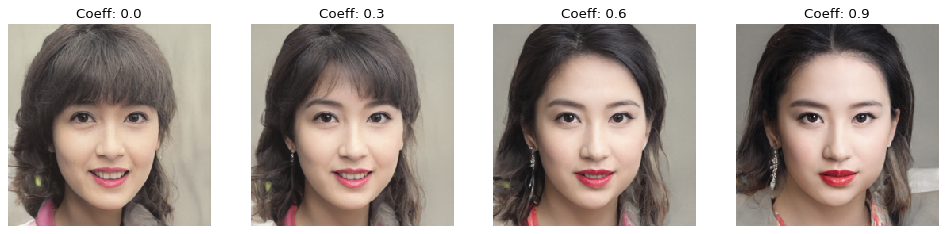

In [10]:
def merge_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        coeff = 0 if coeff < 0 else coeff
        coeff = 1 if coeff > 1 else coeff  
        r1 = 1.0 - coeff 
        r2 = coeff 
        
        new_latent_vector = latent_vector.copy()
        new_latent_vector = latent_vector * r1 + direction * r2
#        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()
    

merge_and_show(lt1, lt2, [0,  0.3, 0.6, 0.9])


In [11]:
# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

# In general it's possible to find directions of almost any face attributes: position, hair style or color ... 
# Additional scripts for doing so will be realised soon

# Smile transformation

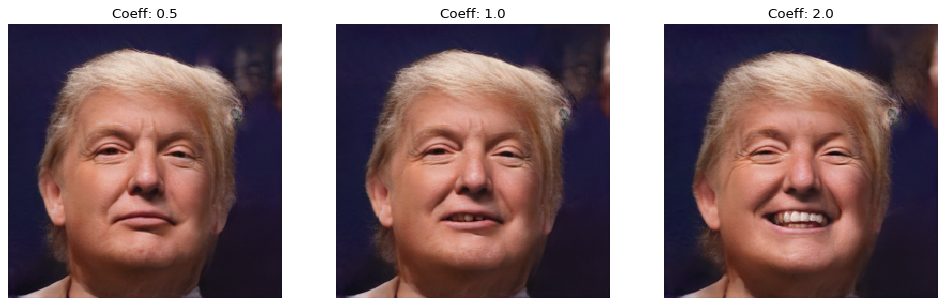

In [12]:
move_and_show(donald_trump, smile_direction, [0.5, 1, 2])

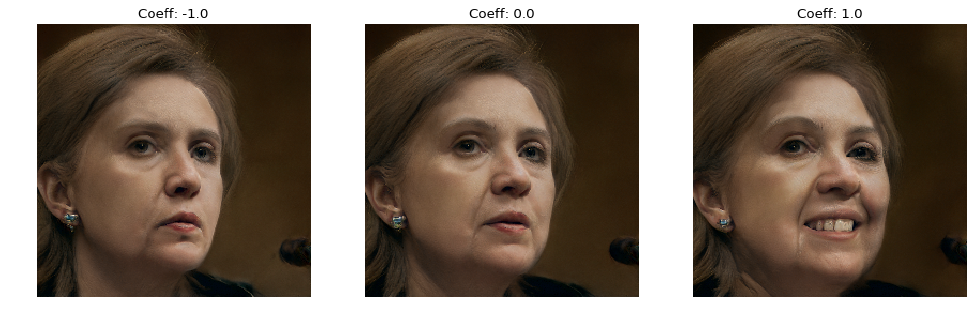

In [12]:
move_and_show(hillary_clinton, smile_direction, [-1, 0, 1])

# Gender transformation

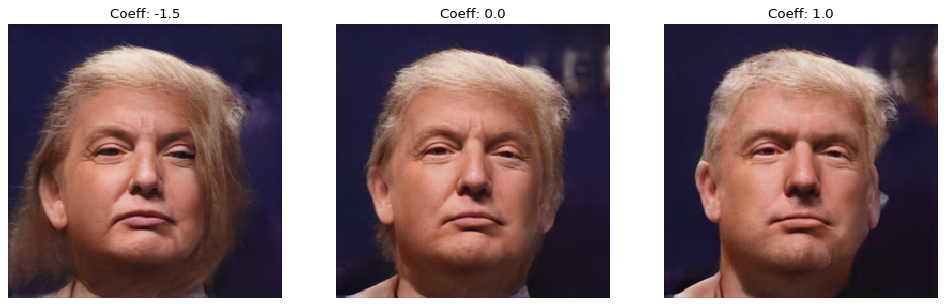

In [14]:
move_and_show(donald_trump, gender_direction, [-1.5, 0, 1.])

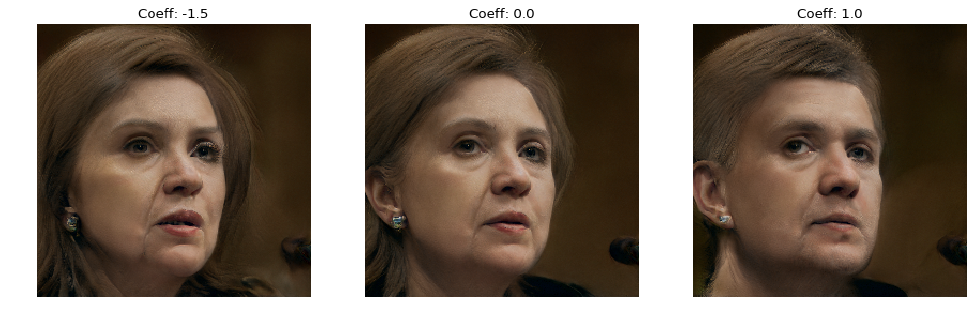

In [15]:
move_and_show(hillary_clinton, gender_direction, [-1.5, 0, 1.])

# Age transformation

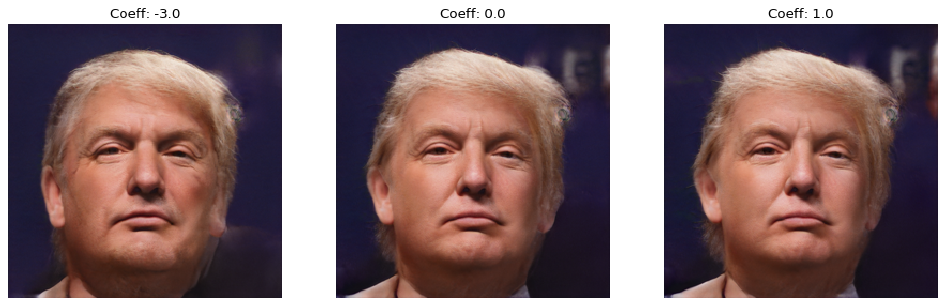

In [15]:
move_and_show(donald_trump, age_direction, [-3, 0, 1])

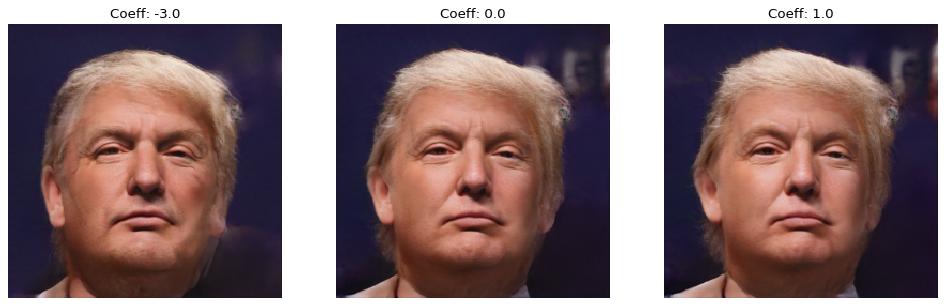

In [16]:
# try it yourself!
move_and_show(donald_trump, age_direction, [-3, 0, 1])